## Intro
As a newly hired machine learning (ML) engineer, you have been tasked with improving 'Cat-titude Enhancer 2000,' a product that utilizes technology to monitor and enhance the well-being of cats through a play gym. The system operates by continuously streaming video footage from a camera installed in the gym, which provides input to your ML model. Based on this data, your system generates an overall recommended recipe with specific calorie counts for the cat to promote happiness, health, and strength.

## Objectives
You only deal with certain specifc backend tasks. These are your high level objectives.
1. Improve cat image classification system. The initial cat classification model was not trained properly and this lead to some complaints from your senior ML engineer.
2. Find a good threshold for cat image classification system. Earlier version of the model detected cat when there were none, the system ended up recommending that the cat be fed more food. Our product is being accused of producing fat cats. We must do something about it.
3. Develop the prototype to take a 'glamour shot' of the cat with a still frame with blurred background. We get internet points if we take an amazing shot of the cat from the video and send it to owner.


We will be using real world data, so your solutions will not be perfect. You will get full mark as long as you prove that you are capable of implementing solutions that uses the computer vision techniques and justify your answers in the context of what is asked.

## Questions
On to assignment proper. Your tasks are:
1. Your predecessor build a training algorithm that just trained for a random number of epochs and assumed that it was the best model. Build an early stopping system for this training, ie, find the number of epochs to train, when the value of a selected quality metric is maximized. Choose an appropriate metric and justify your explanation. [10 marks]


This is the code written by your predecessor.

In [77]:
# Install touch and touch vision

!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [78]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
# Download and load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include images of cats (class 3) and another class (e.g., class 0)
dataset = [(img, label) for img, label in dataset if label in [0, 3]]
trainset = dataset
# Make dataloader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Load the pre-trained MobileNetV2 model and modify last layer
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model and track metrics with MLflow
softmax = nn.Softmax(dim=1)
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))  # convert labels to 0/1
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
best_model = model
THRESHOLD = 0.1

Files already downloaded and verified


/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The metric to be utilized for early stopping is the validation loss. As the validation loss begins to deteriorate, the training process is halted after reaching a certain level of patience.

In [79]:
## Your code here

# Download and load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include images of cats (class 3) and another class (e.g., class 0)
# dataset = [(img, label) for img, label in dataset if label in [0, 3]]

# get image and label from dataset. 
dataset = [(img, label) for img, label in dataset if label in [0, 3]] 
trainset = dataset

# Split dataset into training and validation sets
#Validation set is used to calculate early stoppage
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Initialize variables for early stopping
#starts validation loss at infinity
best_val_loss = float('inf')

# Patience represents the number of epochs to wait 
# before stopping training when the validation loss does not improve
patience = 5
counter = 0

# Load the pre-trained MobileNetV2 model and modify last layer
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Save best model
best_model = model

# Train the model and track metrics with early stopping
# Maximum number of epoch is 100
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # convert labels to 0/1
        labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # print every 125 mini-batches (basically print once every epoch)
        if i % 125 == 124:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
    
    # Validate the model after each epoch
    val_loss = 0.0
    with torch.no_grad(): # Don't compute gradient for this operation
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_labels = torch.where(val_labels==3, torch.tensor([1]), torch.tensor([0]))
            
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
    
            
    print('[Epoch %d] Validation Loss: %.3f' % (epoch + 1, val_loss))
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        best_model = model  # Update the best model
    else:
        counter += 1  # Increment counter if validation loss does not improve
    
    print('counter >> ', counter)
    # Check if early stopping criteria met
    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

Files already downloaded and verified


/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   125] loss: 32.953
[Epoch 1] Validation Loss: 5.285
counter >>  0
[2,   125] loss: 14.892
[Epoch 2] Validation Loss: 4.920
counter >>  0
[3,   125] loss: 11.152
[Epoch 3] Validation Loss: 4.571
counter >>  0
[4,   125] loss: 6.596
[Epoch 4] Validation Loss: 4.440
counter >>  0
[5,   125] loss: 4.838
[Epoch 5] Validation Loss: 5.256
counter >>  1
[6,   125] loss: 5.279
[Epoch 6] Validation Loss: 4.854
counter >>  2
[7,   125] loss: 3.375
[Epoch 7] Validation Loss: 4.932
counter >>  3
[8,   125] loss: 3.070
[Epoch 8] Validation Loss: 5.141
counter >>  4
[9,   125] loss: 3.147
[Epoch 9] Validation Loss: 4.748
counter >>  5
Early stopping triggered. Stopping training.


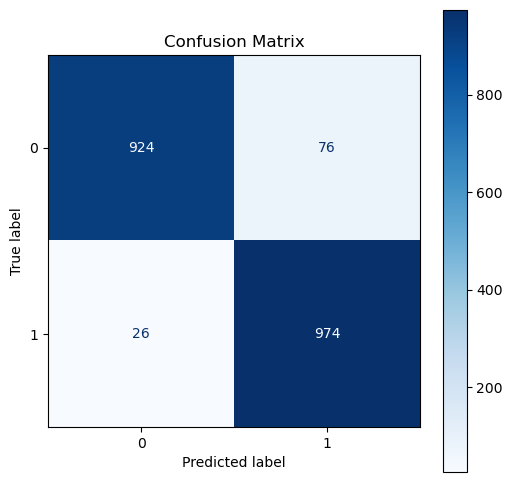

In [80]:
#Compute metrics with 0.1 threshold given.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score


softmax = nn.Softmax(dim=1)
THRESHOLD = 0.1

# Compute validation outputs and labels using the best model
validation_outputs = []
validation_labels = []
for inputs, labels in val_loader:
    outputs = best_model(inputs)
    labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))
    validation_outputs.append(outputs)
    validation_labels.extend(labels)

validation_outputs_tensor = torch.cat(validation_outputs, dim=0)

# Calculate the probabilities of the validation dataset output
validation_probabilities = softmax(validation_outputs_tensor).detach().numpy()
labels = np.array(validation_labels)

y_val_pred = (validation_probabilities[:, 1] >= THRESHOLD).astype(int)

# Compute confusion matrix
cm = confusion_matrix(labels, y_val_pred)

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [81]:
# Calculate TP, FP, TN, FN from confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]


# Calculate Precision, Recall, Specificity, F1 Score, FPR, FNR, Accuracy
precision = precision_score(labels, y_val_pred)
recall = recall_score(labels, y_val_pred)
specificity = TN / (TN + FP)
f1 = f1_score(labels, y_val_pred)
fpr = FP / (FP + TN)
fnr = FN / (FN + TP)
accuracy = accuracy_score(labels, y_val_pred)


print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"False Negative Rate (FNR): {fnr}")
print(f"Accuracy: {accuracy}")

Precision: 0.9276190476190476
Recall (Sensitivity): 0.974
Specificity: 0.924
F1 Score: 0.9502439024390243
False Positive Rate (FPR): 0.076
False Negative Rate (FNR): 0.026
Accuracy: 0.949


2. Compute a threshold that meets the objectives of the larger task. Explain your reasoning clearly. This is an open question, but there are certain range of metrics that makes sense here. [5 marks]

#### Answer


The earlier version of the model detected cats even when they were not present, highlighting the need to reduce the false positive rate.

In the context of improving the cat image classification system with a focus on reducing false positives, the main objective is to maximize specificity. This is crucial to ensure that images without cats are correctly identified as negative cases, addressing the complaints and concerns raised by the senior ML engineer.

When analyzing the ROC curve and AUC, the trade-off between sensitivity and specificity at different thresholds was observed. Given that both false positives and false negatives hold similar importance in the task, an effort was made to balance sensitivity and specificity, with both metrics being prioritized equally.

After evaluating various thresholds, a threshold was chosen that optimizes the overall performance across both classes by maximizing the difference between true positive rate (TPR) and false positive rate (FPR). This approach allows for the identification of a threshold that minimizes false positives while maintaining a reasonable level of false negatives.

The reasoning behind this threshold selection is rooted in the necessity to enhance the model's accuracy in identifying images without cats, thereby addressing the complaints and ensuring a more reliable and accurate classification system.

Overall, the threshold selected optimizes both sensitivity and specificity, leading to a balanced performance that reduces false positives and false negatives, aligning with the objective of enhancing the cat image classification system's performance.

The corresponding code is provided below.

Threshold is 0.32307350635528564


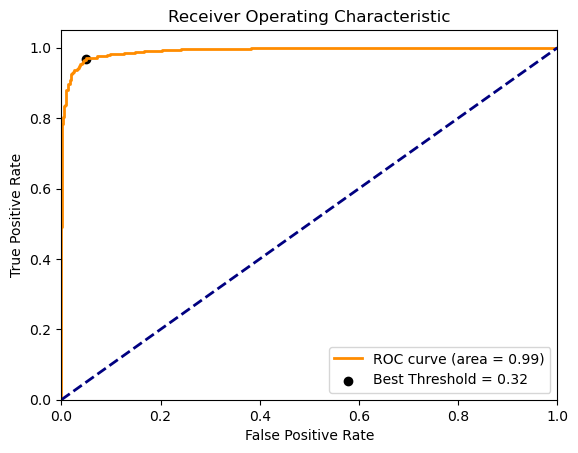

In [82]:
# Now we calculate the optimal threshold taking into account the objective.

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

softmax = nn.Softmax(dim=1)

# Compute validation outputs and labels using the best model
best_validation_outputs = []
validation_labels = []
for inputs, labels in val_loader:
    outputs = best_model(inputs)
    labels = torch.where(labels==3, torch.tensor([1]), torch.tensor([0]))
    best_validation_outputs.append(outputs)
    validation_labels.extend(labels)

best_validation_outputs_tensor = torch.cat(best_validation_outputs, dim=0)

# Calculate the probabilities of the validation dataset output
probabilities = softmax(best_validation_outputs_tensor).detach().numpy()
labels = np.array(validation_labels)

fpr, tpr, thresholds = roc_curve(labels, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Find the best threshold
optimal_idx = np.argmax(tpr - fpr)
THRESHOLD = thresholds[optimal_idx]

print(f"Threshold is {THRESHOLD}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold = %0.2f' % THRESHOLD)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

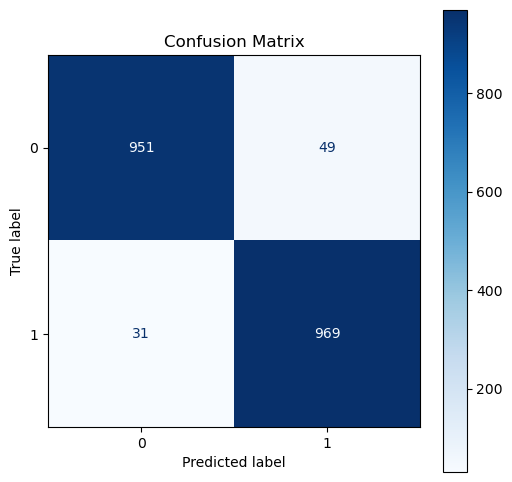

In [83]:
y_best_val_pred = (probabilities[:, 1] >= THRESHOLD).astype(int)

# Compute confusion matrix
cm = confusion_matrix(labels, y_best_val_pred)

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [84]:
# Calculate TP, FP, TN, FN from confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]


# Calculate Precision, Recall, Specificity, F1 Score, FPR, FNR, Accuracy
precision = precision_score(labels, y_val_pred)
recall = recall_score(labels, y_val_pred)
specificity = TN / (TN + FP)
f1 = f1_score(labels, y_val_pred)
fpr = FP / (FP + TN)
fnr = FN / (FN + TP)
accuracy = accuracy_score(labels, y_val_pred)


print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"False Negative Rate (FNR): {fnr}")
print(f"Accuracy: {accuracy}")

Precision: 0.9276190476190476
Recall (Sensitivity): 0.974
Specificity: 0.951
F1 Score: 0.9502439024390243
False Positive Rate (FPR): 0.049
False Negative Rate (FNR): 0.031
Accuracy: 0.949


 We notice an increase in specitivity

3. Build a cat photo capture system that stores the best image of the cat and blurs the background. We provided you with a randomly picked sample video.

  For this assignment, we will define the best image as the one in which the cat occupies the most area on screen. So your objectives are
    1. Iterate through every frame of video, use the classifer you trained with the threshold you designed to count the number of frames in which there is a cat. `[5 marks]`
    2. If a cat is detected, segment the cat and enhance the image. The enhanced image could have either (do one of these).  `[15 marks]`
      - Blurred background background. Use `GaussianBlur` function in opencv to achieve the blur effect.
      - White background.      
    3. Figure out a logic to find out the frame in which the cat occupies most area and save/display that image. The file name of that should be `cat_<current_time>_<number_of_frames>.jpg`. `[5 marks]`

Notes and hints
- The results here need not be perfect, you will have blurred image of the cat because of motion in the video. For the scope of this assignment, motion blur in the image is acceptable.
- Use maskRCNN.
- Use pretrained model from torch vision.  
- Video itself is long, but for experimentation first 50 frames will be enough to get you some good samples of cats.
- Try `sample_video2.mp4` first, then `sample_video.mp4`.
- The videos are provided for educationl use only, from https://www.pexels.com/search/videos/cat%20jump/. Please donot redistrubute the sample videos.

Here is some sample code to read the video file to get you started.

In [85]:
import os

# The code below minimizes the amount of downloads when you rerun all cells.
# You probably don't need to download the same file over and over again...
if os.path.isfile('sample_video2.mp4'):
    print('File already exists! Delete the file to force download again...')
else:
    !wget -O sample_video2.mp4 'https://docs.google.com/uc?export=download&id=1wQDX5uu56NOLVPXQtngjeA4Cy5gygd_6&confirm=t'

if os.path.isfile('sample_video.mp4'):
    print('File already exists! Delete the file to force download again...')
else:
    !wget -O sample_video.mp4 'https://docs.google.com/uc?export=download&id=1mkAjevnCeZDefXrDIu9N-2qIxDngPbL0&confirm=t'


File already exists! Delete the file to force download again...
File already exists! Delete the file to force download again...


#### ANSWER TO Question 3A

Count the number of cat frames in the image

In [86]:
# Load the trained model
# If your model is on GPU, move it to CPU for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = best_model.to(device)
model.eval()  # Set the model to evaluation mode


video_path = 'sample_video2.mp4'
cap = cv2.VideoCapture(video_path)

# Define a threshold for cat detection
threshold = THRESHOLD

# Variables to track the number of frames with a cat
total_frames = 0
cat_frames = 0

frame_300 = None

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (resize, normalize, convert to tensor)
    frame = cv2.resize(frame, (224, 224))  # Adjust the size as per your model's input size
    frame = frame.astype(float) / 255.0  # Normalize to [0, 1]
    frame = torch.tensor(frame.transpose((2, 0, 1)), dtype=torch.float32).unsqueeze(0).to(device)
    

    # Pass the frame through the classifier
    with torch.no_grad():
        output = model(frame)

        prob = torch.softmax(output, dim=1)[0][1].item()

    # Check if cat is detected based on threshold
    if prob > threshold:
        cat_frames += 1

    total_frames += 1

# Release the video capture object
cap.release()

# Print the results
print(f"Total frames: {total_frames}")
print(f"Frames with cat: {cat_frames}")


Total frames: 367
Frames with cat: 367


#### ANSWER TO QUESTION 3B and 3C

/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cifedior/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing frames...


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


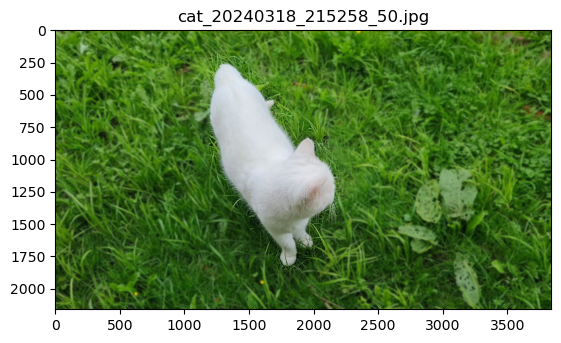

In [87]:
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision.transforms import functional as F
from tqdm import tqdm
import datetime

TOTAL_FRAME_LIMIT = 50  # Adjust this as needed
framecount = 0
best_cat_frame = None
best_cat_mask = None
largest_cat_area = 0

# Load Mask R-CNN model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

def blur_background(image, mask, kernel_size=(21, 21)):
    # Apply Gaussian blur to the background based on the mask
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    output = image.copy()
    output[mask == 0] = blurred[mask == 0]
    return output

def process_frame(frame):
    global framecount, best_cat_frame, best_cat_mask, largest_cat_area
    framecount += 1
    
    # Convert BGR frame to RGB for Mask R-CNN
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    tensor_img = F.to_tensor(frame_rgb).unsqueeze(0)

    with torch.no_grad():
        predictions = model(tensor_img)[0]
    
    cat_predictions = [pred for pred in predictions['labels'] if pred == 17] 
    
    if cat_predictions:
        # Find the mask with the largest area (assuming cat occupies most area)
        largest_mask_idx = torch.argmax(predictions['scores']).item()
        best_mask = predictions['masks'][largest_mask_idx, 0].mul(255).byte().cpu().numpy()
        cat_area = cv2.countNonZero(best_mask)
        
        if cat_area > largest_cat_area:
            largest_cat_area = cat_area
            best_cat_frame = frame
            best_cat_mask = best_mask

# Read sample file and process frames
cap = cv2.VideoCapture("sample_video2.mp4")
if not cap.isOpened():
    print("Error opening video file")
    exit(1)

print("Processing frames...")
for _ in tqdm(range(TOTAL_FRAME_LIMIT)):
    ret, frame = cap.read()
    if ret:
        process_frame(frame)
    else:
        break

cap.release()

# Apply background enhancement 

# Method 1: Blurred background
best_cat_frame_blur = blur_background(best_cat_frame, best_cat_mask, kernel_size=(31, 31))

# Save/display the best image
filename = f"cat_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{framecount}.jpg"
cv2.imwrite(filename, best_cat_frame_blur)
plt.imshow(cv2.cvtColor(best_cat_frame_blur, cv2.COLOR_BGR2RGB))
plt.title(f"{filename}")
plt.show()


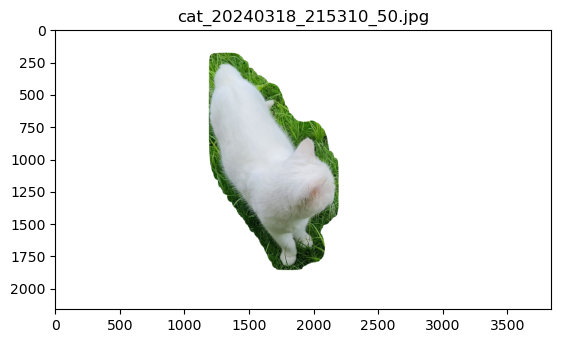

In [88]:
# Method 2: White background
best_cat_frame_white = best_cat_frame.copy()
best_cat_frame_white[best_cat_mask == 0] = [255, 255, 255]  # Set non-cat pixels to white

# Save/display the best image
filename = f"cat_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{framecount}.jpg"
cv2.imwrite(filename, best_cat_frame_white)
plt.imshow(cv2.cvtColor(best_cat_frame_white, cv2.COLOR_BGR2RGB))
plt.title(f"{filename}")
plt.show()

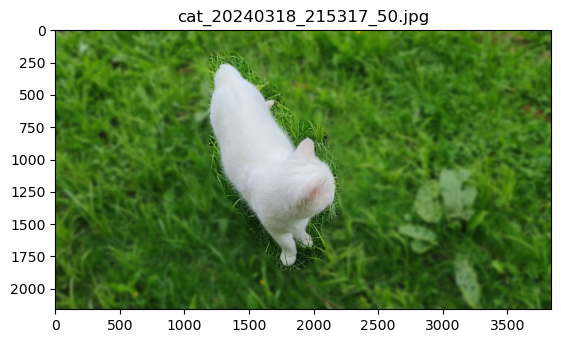

In [89]:
# Method 3: Blurred background
# Apply background enhancement with increased blur
best_cat_frame_very_blur = blur_background(best_cat_frame, best_cat_mask, kernel_size=(71, 71))  # Adjust kernel size as needed

# Save/display the best image
filename = f"cat_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{framecount}.jpg"
cv2.imwrite(filename, best_cat_frame_very_blur)
plt.imshow(cv2.cvtColor(best_cat_frame_very_blur, cv2.COLOR_BGR2RGB))
plt.title(f"{filename}")
plt.show()

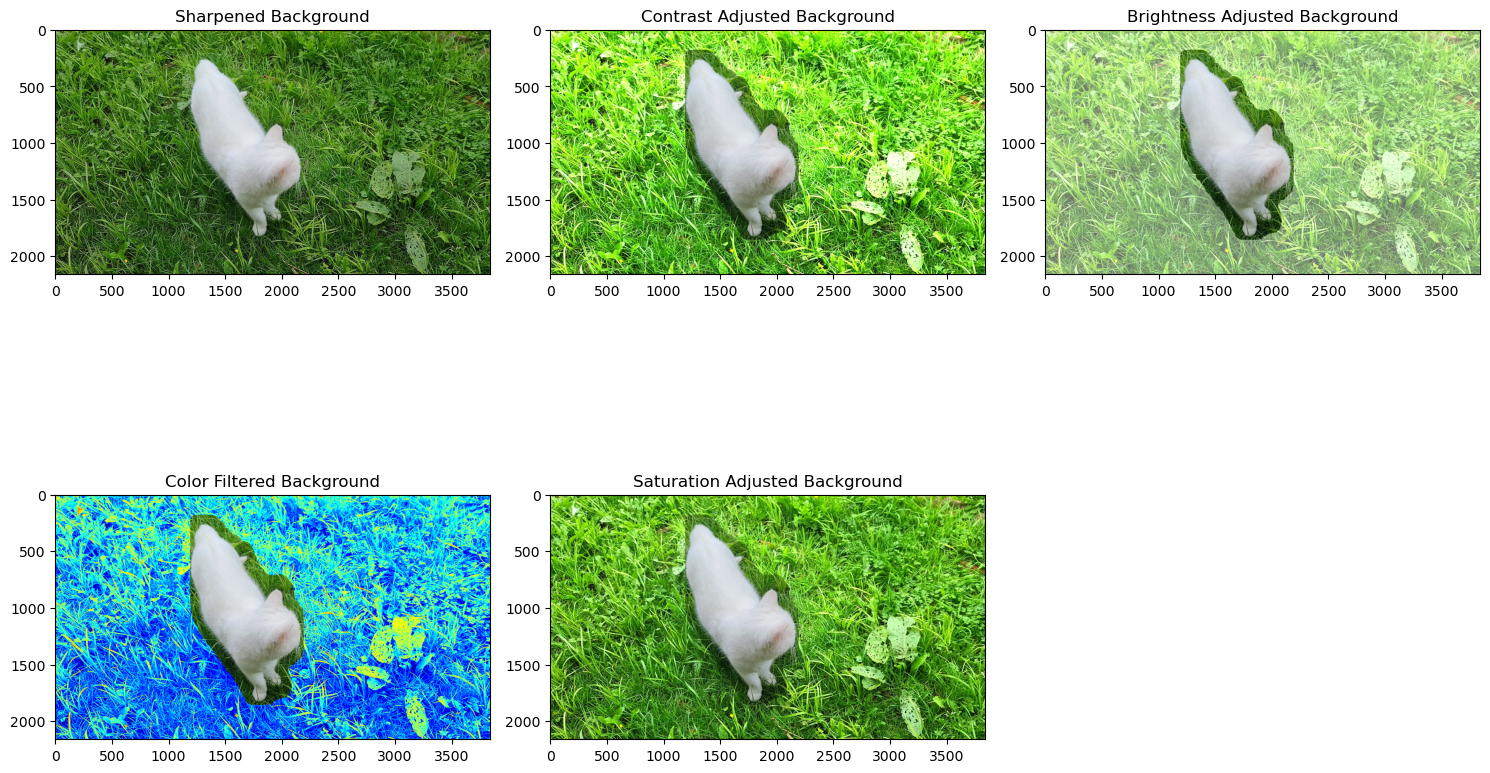

In [90]:
def apply_effects(image, mask):
    # Apply different effects to the background of the image based on the mask
    
    sharpened = cv2.filter2D(image, -1, kernel=np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    contrast = cv2.convertScaleAbs(image, alpha=2.0, beta=0)
    brightness = cv2.convertScaleAbs(image, alpha=1.0, beta=100)
    filtered = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    saturated = cv2.convertScaleAbs(image, alpha=1.5, beta=0)

    output_sharpened = image.copy()
    output_contrast = image.copy()
    output_brightness = image.copy()
    output_filtered = image.copy()
    output_saturated = image.copy()

    output_sharpened[mask == 0] = sharpened[mask == 0]
    output_contrast[mask == 0] = contrast[mask == 0]
    output_brightness[mask == 0] = brightness[mask == 0]
    output_filtered[mask == 0] = filtered[mask == 0]
    output_saturated[mask == 0] = saturated[mask == 0]

    return output_sharpened, output_contrast, output_brightness, output_filtered, output_saturated

# Apply effects to the background of the best cat frame based on the mask
sharpened, contrast, brightness, filtered, saturated = apply_effects(best_cat_frame, best_cat_mask)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
plt.title("Sharpened Background")

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(contrast, cv2.COLOR_BGR2RGB))
plt.title("Contrast Adjusted Background")

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(brightness, cv2.COLOR_BGR2RGB))
plt.title("Brightness Adjusted Background")

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
plt.title("Color Filtered Background")

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(saturated, cv2.COLOR_BGR2RGB))
plt.title("Saturation Adjusted Background")

plt.tight_layout()
plt.show()

Extra tasks if you are interested
- Make this real time.  
- Use image quality metric to take the frame with the best image of the cat
- Improve segmentation with Segment anything model.

In [93]:
TOTAL_FRAME_LIMIT = 50  # Adjust this as needed
framecount = 0
largest_cat_area = 0

# Load Mask R-CNN model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

def blur_background(image, mask, kernel_size=(21, 21)):
    # Apply Gaussian blur to the background based on the mask
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    output = image.copy()
    output[mask == 0] = blurred[mask == 0]
    return output

def process_frame(frame):
    global framecount, largest_cat_area
    framecount += 1
    
    # Convert BGR frame to RGB for Mask R-CNN
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    tensor_img = F.to_tensor(frame_rgb).unsqueeze(0)

    with torch.no_grad():
        predictions = model(tensor_img)[0]
    
    cat_predictions = [pred for pred in predictions['labels'] if pred == 17] 
    
    if cat_predictions:
        # Find the mask with the largest area (assuming cat occupies most area)
        largest_mask_idx = torch.argmax(predictions['scores']).item()
        best_mask = predictions['masks'][largest_mask_idx, 0].mul(255).byte().cpu().numpy()
        cat_area = cv2.countNonZero(best_mask)
        
        if cat_area > largest_cat_area:
            largest_cat_area = cat_area
            best_cat_frame = frame
            best_cat_mask = best_mask

# Start video capture
cap = cv2.VideoCapture(0)  # Use 0 for webcam or provide the video file path

if not cap.isOpened():
    print("Error opening video capture")
    exit(1)

# Initialize variables for real-time processing
best_cat_frame = None
best_cat_mask = None

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error reading frame")
        break
    
    # Process the frame
    process_frame(frame)
    
    # Apply background enhancement in real-time
    if best_cat_frame is not None and best_cat_mask is not None:
        best_cat_frame_blur = blur_background(best_cat_frame, best_cat_mask, kernel_size=(31, 31))
        
        # Display the processed frame
        cv2.imshow("Real-Time Background Enhancement", best_cat_frame_blur)
    
    # Exit loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close all windows
cap.release()
cv2.destroyAllWindows()


Error reading frame


[ WARN:0@36434.339] global cap_v4l.cpp:887 requestBuffers VIDEOIO(V4L2:/dev/video0): failed VIDIOC_REQBUFS: errno=19 (No such device)
